# Import required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

from io import StringIO
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.metrics import mean_squared_error
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.figure_factory as ff
import plotly

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    display.precision = 8  # set as needed

set_pandas_display_options()

In [2]:
trainDf = pd.read_csv('train.csv')
trainDf.replace("nan", np.nan, inplace=True)

testDf = pd.read_csv('test.csv')
testDf.replace("nan", np.nan, inplace=True)

trainDf.columns = ['_'.join(col.split(' ')) for col in trainDf.columns]
testDf.columns = ['_'.join(col.split(' ')) for col in testDf.columns]

print(f"\nTrain Data Size : {trainDf.shape}")
print(f"Test Data Size : {testDf.shape}")

print(f"\n\n:: Train Data Sample ::")
display(trainDf.head())

target_feat = 'Credit_Default'


Train Data Size : (7500, 18)
Test Data Size : (2500, 17)


:: Train Data Sample ::


Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0   0       Own Home       482087.0                  NaN        0.0   
1   1       Own Home      1025487.0            10+ years        0.0   
2   2  Home Mortgage       751412.0              8 years        0.0   
3   3       Own Home       805068.0              6 years        0.0   
4   4           Rent       776264.0              8 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current_Loan_Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

# Features Data Types

In [3]:
def dataset_datatypes_counts(data, col_sample_size):
    '''
    Identifies the Numerical, Categorial, Text, and Temporal(DateTime) features of the input dataframe.
    Considers the 
    Prints the different datatype columns along with a random sample values from each feature for a quick eyeball check of data
    This method is for just getting an understanding of different datatypes variables we have in the dataset. 
    Be cautious about the year feature
    '''
    # Caterogies mentioned as numerical values need to be considered as categories
    buf = StringIO()
    data.info(buf=buf)
    print(f"""\n:: Train Data Info ::\n\n{buf.getvalue()}""")

    string_vars_list = []
    categorical_vars_list = []
    numerical_vars_list = []

    numerical_vars_w_random_sample_list = []
    categorical_vars_w_random_sample_list = []
        
    for i in list(data.select_dtypes(include=[np.number, np.float64, np.float32]).columns):
#         if len(data[i].unique()) <= 5:
#             categorical_vars_list.append(i)
#             categorical_vars_w_random_sample_list.append(f"{i} - {data[i].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#         else:
#             numerical_vars_list.append(i)
#             numerical_vars_w_random_sample_list.append(f"{i} - {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#             #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")
        numerical_vars_list.append(i)
        numerical_vars_w_random_sample_list.append(f"{i} :\n {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}\n")
        #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")            
    
    
    for cat_name in list(data.select_dtypes(include=['category', 'object']).columns):
        if len(data[cat_name].unique()) > 50:
            string_vars_list.append(cat_name)
        else:
            categorical_vars_list.append(cat_name)
            categorical_vars_w_random_sample_list.append(f"{cat_name} :\n {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
            # print(f"{cat_name} - {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")

    temporal_vars_list = list(data.select_dtypes(include=['datetime', 'datetime64', 'timedelta', 'timedelta64', 'datetimetz']).columns)
    
    print(f"#########################################################################")
    print(f"\n:: Numerical Features :: {len(numerical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(numerical_vars_w_random_sample_list))}\n""")
    print(f"#########################################################################")
    print(f"\n:: Categorical Features :: {len(categorical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(categorical_vars_w_random_sample_list))}\n")
    print(f"#########################################################################")
    print(f"\n:: String/Text Features :: {len(string_vars_list)}\n{string_vars_list}\n")
    print(f"#########################################################################")
    print(f"\n:: Temporal/Datetime Features :: {len(temporal_vars_list)}\n{chr(10).join(sorted(temporal_vars_list))}\n")
    print(f"#########################################################################")

    print(f"\nDateframe Rows: {data.shape[0]},   Columns: {data.shape[1]}")
    print(f"Numerical({len(numerical_vars_w_random_sample_list)}) + Categorical({len(categorical_vars_w_random_sample_list)}) + Text({len(string_vars_list)}) + Temporal({len(temporal_vars_list)}) = {len(numerical_vars_w_random_sample_list)+len(categorical_vars_w_random_sample_list)+len(string_vars_list)+len(temporal_vars_list)}")
    
    return numerical_vars_list, categorical_vars_list, string_vars_list, temporal_vars_list

num_feat, cat_feat, text_feat, datetime_feat = dataset_datatypes_counts(data=trainDf, col_sample_size=10)

print(f"\nNumerical Features :\n{num_feat}")
print(f"\nCategorical Features :\n{cat_feat}")
print(f"\nString/Text Features :\n{text_feat}")
print(f"\nTemporal/DateTime Features :\n{datetime_feat}")


:: Train Data Info ::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home_Ownership                7500 non-null   object 
 2   Annual_Income                 5943 non-null   float64
 3   Years_in_current_job          7129 non-null   object 
 4   Tax_Liens                     7500 non-null   float64
 5   Number_of_Open_Accounts       7500 non-null   float64
 6   Years_of_Credit_History       7500 non-null   float64
 7   Maximum_Open_Credit           7500 non-null   float64
 8   Number_of_Credit_Problems     7500 non-null   float64
 9   Months_since_last_delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non

# Target Label Counts

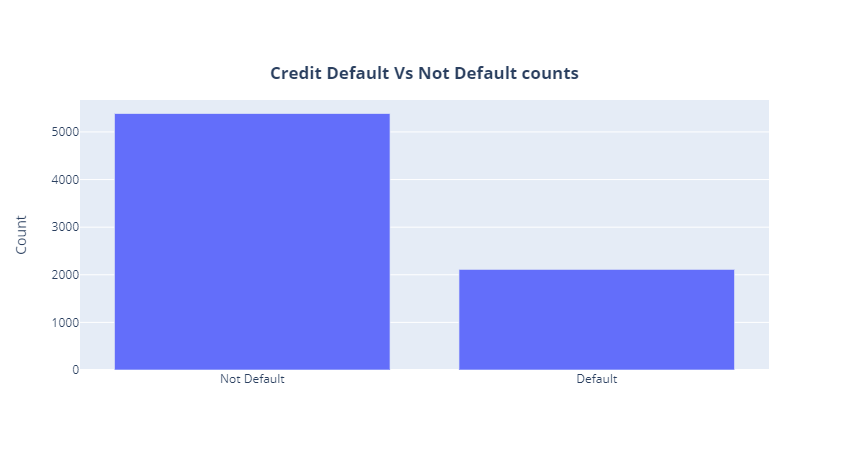

In [4]:
s = trainDf[target_feat].value_counts()
s.index = ['Not Default', 'Default']
df = pd.DataFrame({'Default_Status':s.index, 'count':s.values})

fig = go.Figure(
    data=[
        go.Bar(
            name="Default",
            x=df['Default_Status'],
            y=df["count"],
            offsetgroup=0,
        ),
    ],
    layout=go.Layout(
        title="<b>Credit Default Vs Not Default counts",
        yaxis_title="Count",
        title_x=0.5,
        title_y=0.85,
        title_xanchor='center',
        title_yanchor='top'
    )
)
fig.show()

# Features Missing Values

In [5]:
trainMissingValCount = trainDf.isnull().sum().sort_values(ascending=False)
testMissingValCount = testDf.isnull().sum().sort_values(ascending=False)

print(f"Train Data features having missing values :: {np.count_nonzero(trainMissingValCount)}")
print(f"\nTest Data features having missing values :: {np.count_nonzero(testMissingValCount)}\n")

missingDataDf = pd.concat([trainMissingValCount, testMissingValCount], axis=1)
missingDataDf.columns = ['Train', 'Test']
missingDataDf = missingDataDf.fillna(0)
missingDataDf

Train Data features having missing values :: 5

Test Data features having missing values :: 5



Train    Test
Months_since_last_delinquent   4081  1358.0
Annual_Income                  1557   513.0
Credit_Score                   1557   513.0
Years_in_current_job            371    86.0
Bankruptcies                     14     3.0
Credit_Default                    0     0.0
Years_of_Credit_History           0     0.0
Home_Ownership                    0     0.0
Tax_Liens                         0     0.0
Number_of_Open_Accounts           0     0.0
Number_of_Credit_Problems         0     0.0
Maximum_Open_Credit               0     0.0
Purpose                           0     0.0
Term                              0     0.0
Current_Loan_Amount               0     0.0
Current_Credit_Balance            0     0.0
Monthly_Debt                      0     0.0
Id                                0     0.0

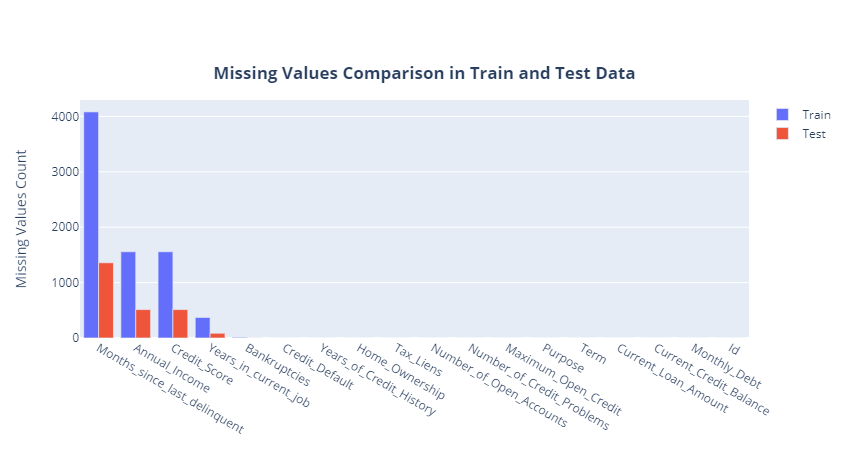

In [6]:
fig1 = go.Figure(
    data=[
        go.Bar(
            name="Train",
            x=missingDataDf.index,
            y=missingDataDf["Train"],
            offsetgroup=0,
        ),
        go.Bar(
            name="Test",
            x=missingDataDf.index,
            y=missingDataDf["Test"],
            offsetgroup=1,
        ),
    ],
    layout=go.Layout(
        title="<b>Missing Values Comparison in Train and Test Data",
        yaxis_title="Missing Values Count",
        title_x=0.5,
        title_y=0.85,
        title_xanchor='center',
        title_yanchor='top'
    )
)
fig1.show()

In [7]:
# List the features having missing values
feat_w_missing_values_list = trainDf.columns[trainDf.isna().any()].tolist()

print(f"Features with missing values : {len(feat_w_missing_values_list)}\n\n{feat_w_missing_values_list}")

# percentage of missing values
total = trainDf.isnull().sum().sort_values(ascending=False)
percent = (trainDf.isnull().sum()/trainDf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

Features with missing values : 5

['Annual_Income', 'Years_in_current_job', 'Months_since_last_delinquent', 'Bankruptcies', 'Credit_Score']


Total     Percent
Months_since_last_delinquent   4081  0.54413333
Annual_Income                  1557  0.20760000
Credit_Score                   1557  0.20760000
Years_in_current_job            371  0.04946667
Bankruptcies                     14  0.00186667
Credit_Default                    0  0.00000000
Years_of_Credit_History           0  0.00000000
Home_Ownership                    0  0.00000000
Tax_Liens                         0  0.00000000
Number_of_Open_Accounts           0  0.00000000
Number_of_Credit_Problems         0  0.00000000
Maximum_Open_Credit               0  0.00000000
Purpose                           0  0.00000000
Term                              0  0.00000000
Current_Loan_Amount               0  0.00000000
Current_Credit_Balance            0  0.00000000
Monthly_Debt                      0  0.00000000
Id                                0  0.00000000

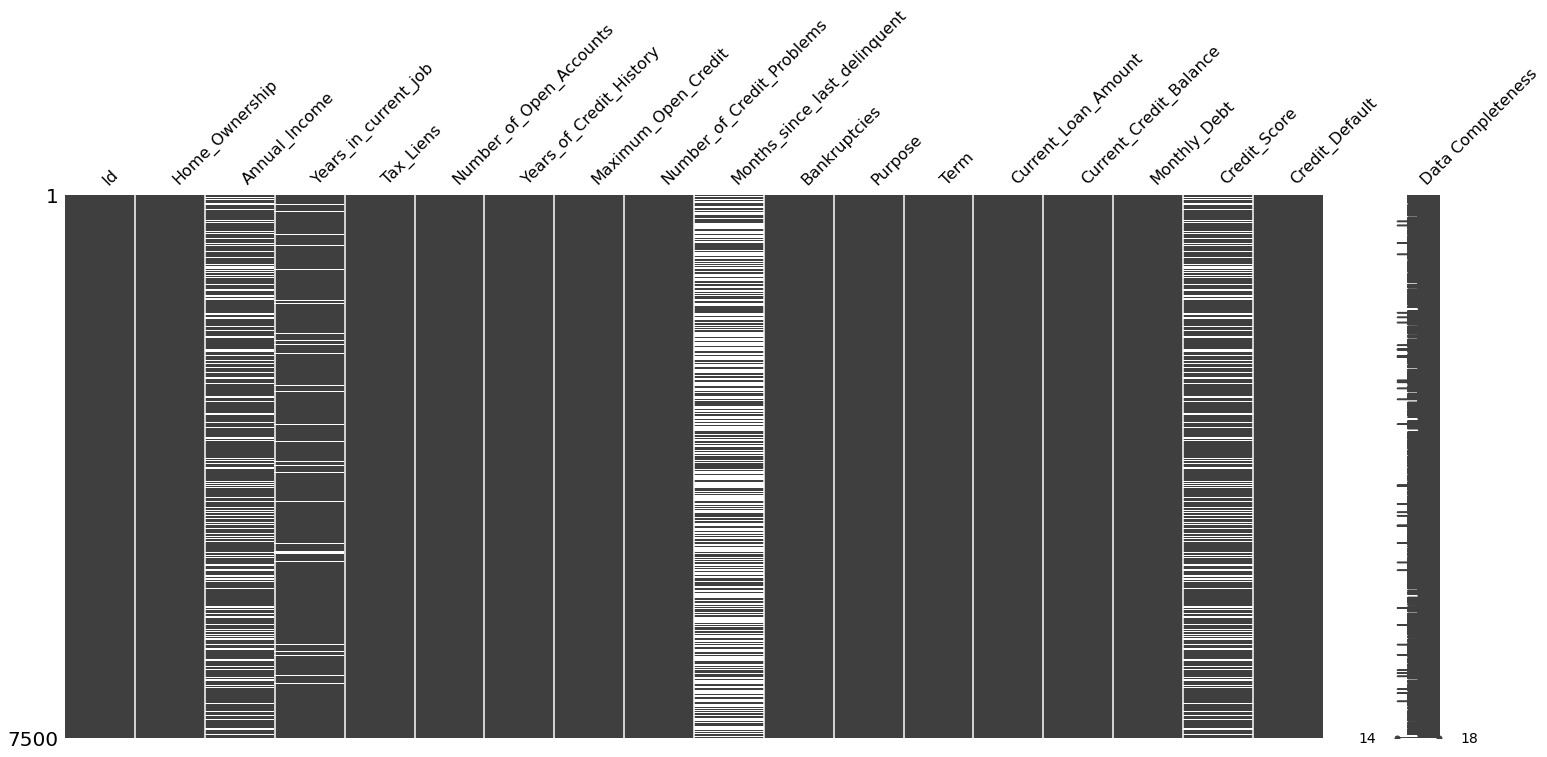

In [8]:
filtered_data = msno.nullity_filter(trainDf, filter='top', p=0.20)
msno.matrix(filtered_data, labels=True);

<AxesSubplot:>

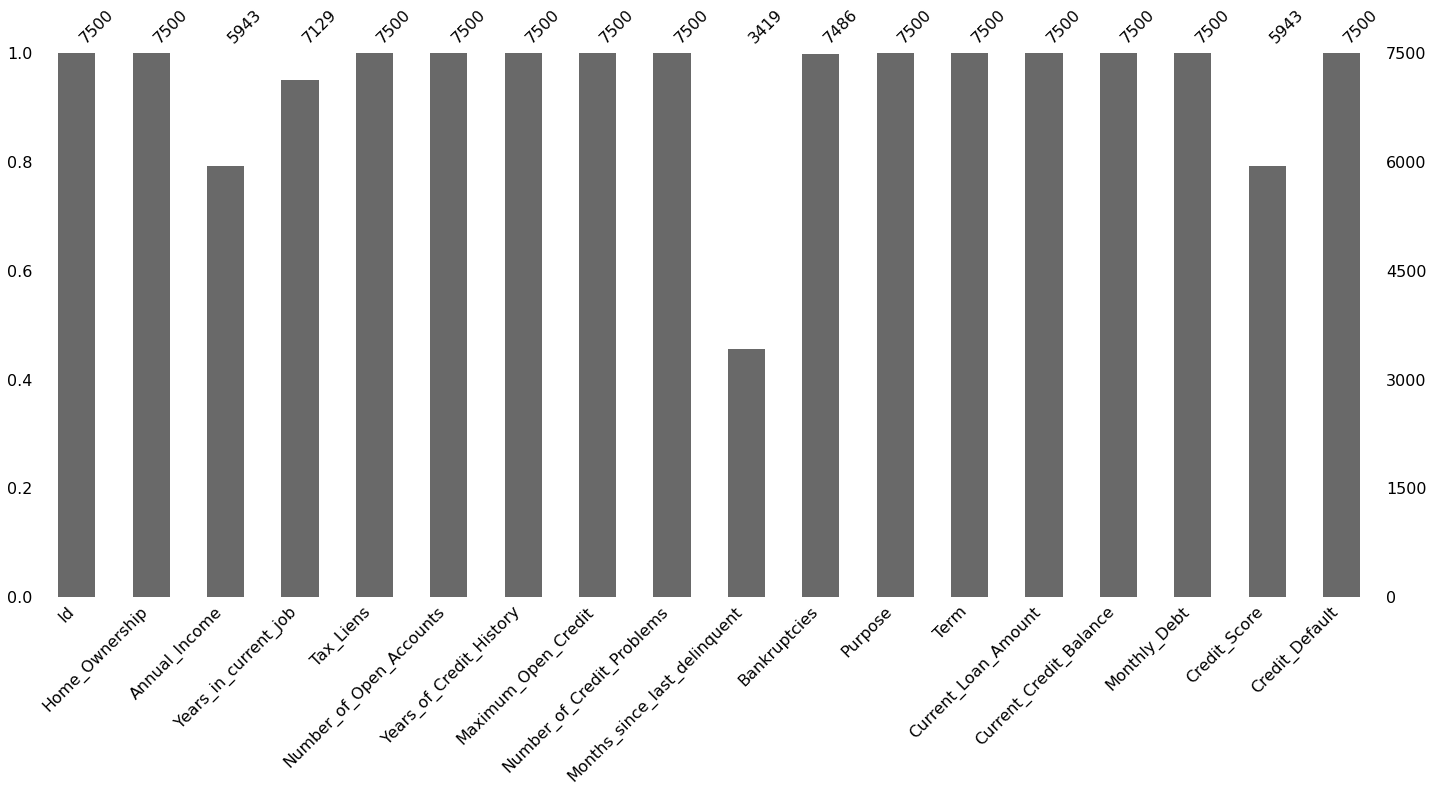

In [9]:
msno.bar(trainDf)

<AxesSubplot:>

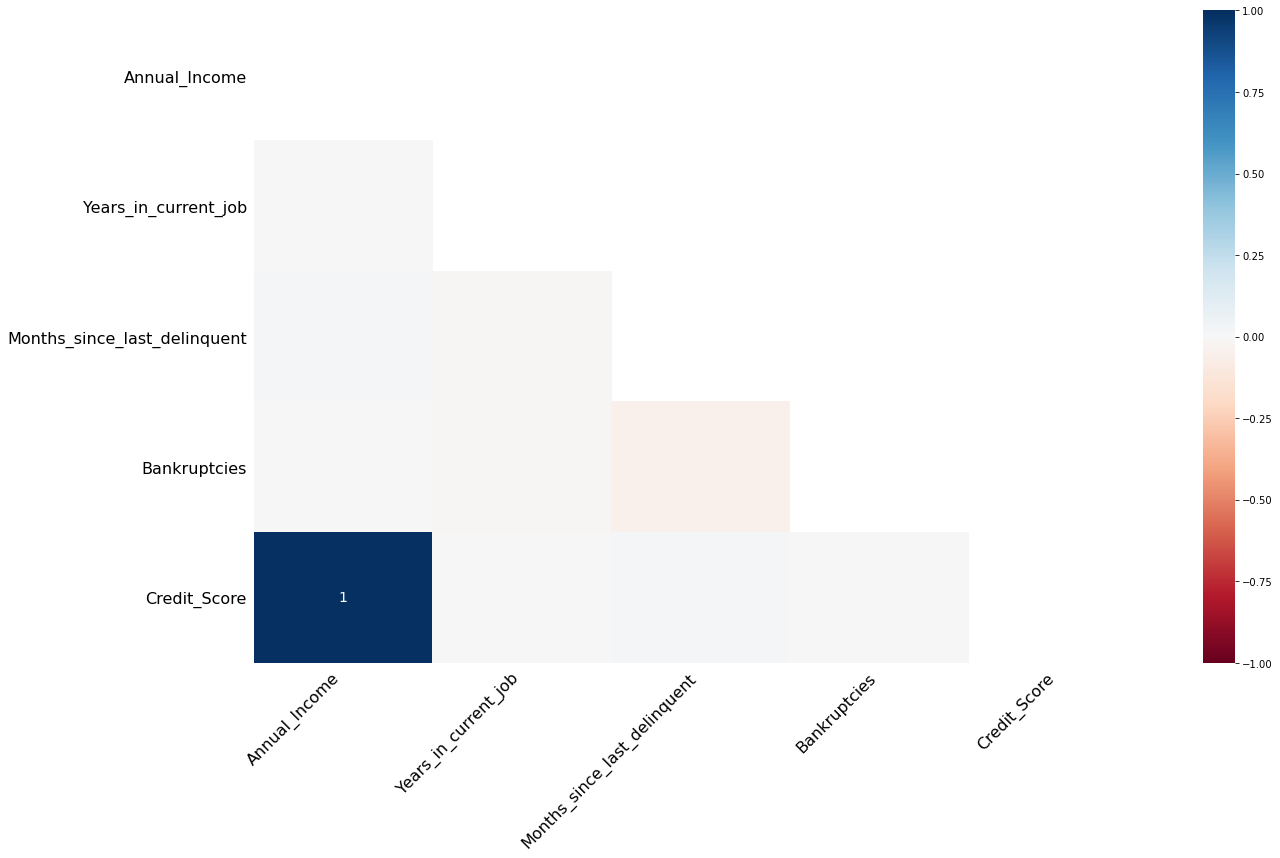

In [10]:
msno.heatmap(trainDf)

<AxesSubplot:>

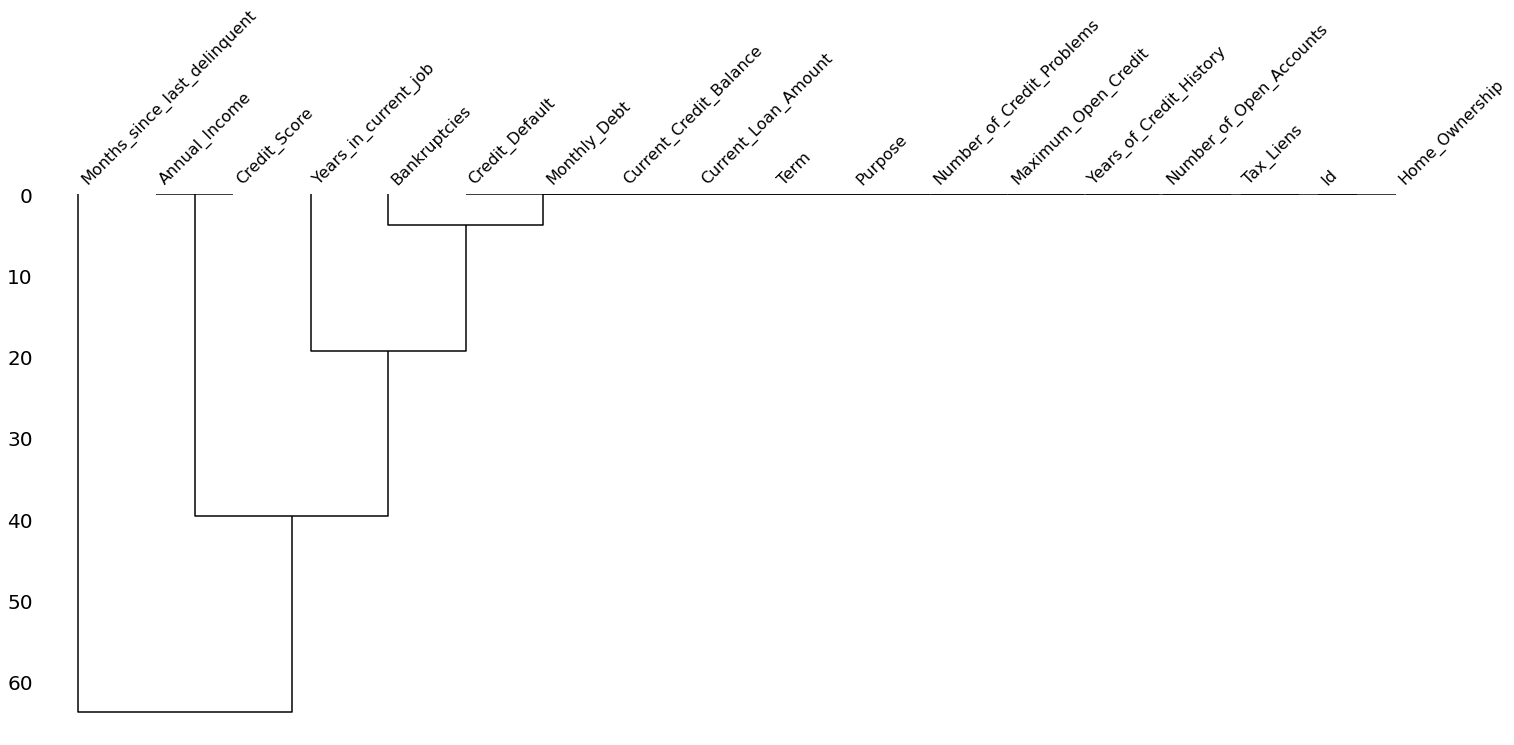

In [11]:
msno.dendrogram(trainDf)

# Encoding Categorical Features

In [268]:
# print(trainDf['Home_Ownership'].isnull().sum())
# print(trainDf['Purpose'].isnull().sum())
# print(trainDf['Term'].isnull().sum())

# trainDf = pd.get_dummies(data=trainDf, columns=['Home_Ownership', 'Purpose', 'Term'], prefix=['Home_Ownership', 'Purpose', 'Term'])
# trainDf

In [12]:
trainDf['Years_in_current_job'] = trainDf['Years_in_current_job'].map({'10+ years': 10, '9 years': 9, '8 years': 8, '7 years': 7, '6 years': 6, '5 years': 5, '4 years': 4, 
 '3 years': 3, '2 years': 2, '1 year': 1, '< 1 year': 0.5 })
trainDf

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
0        0       Own Home       482087.0                   NaN        0.0   
1        1       Own Home      1025487.0                  10.0        0.0   
2        2  Home Mortgage       751412.0                   8.0        0.0   
3        3       Own Home       805068.0                   6.0        0.0   
4        4           Rent       776264.0                   8.0        0.0   
...    ...            ...            ...                   ...        ...   
7495  7495           Rent       402192.0                   0.5        0.0   
7496  7496  Home Mortgage      1533984.0                   1.0        0.0   
7497  7497           Rent      1878910.0                   6.0        0.0   
7498  7498  Home Mortgage            NaN                   NaN        0.0   
7499  7499           Rent            NaN                   4.0        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0                    47386.0        7914.0         749.0               0  
1                   394972.0       18373.0         737.0               1  
2                   308389.0       13651.0         742.0               0  
3                    95855.0       11338.0         694.0               0  
4                    93309.0        7180.0         719.0               0  
..

# Features Correlation with Target

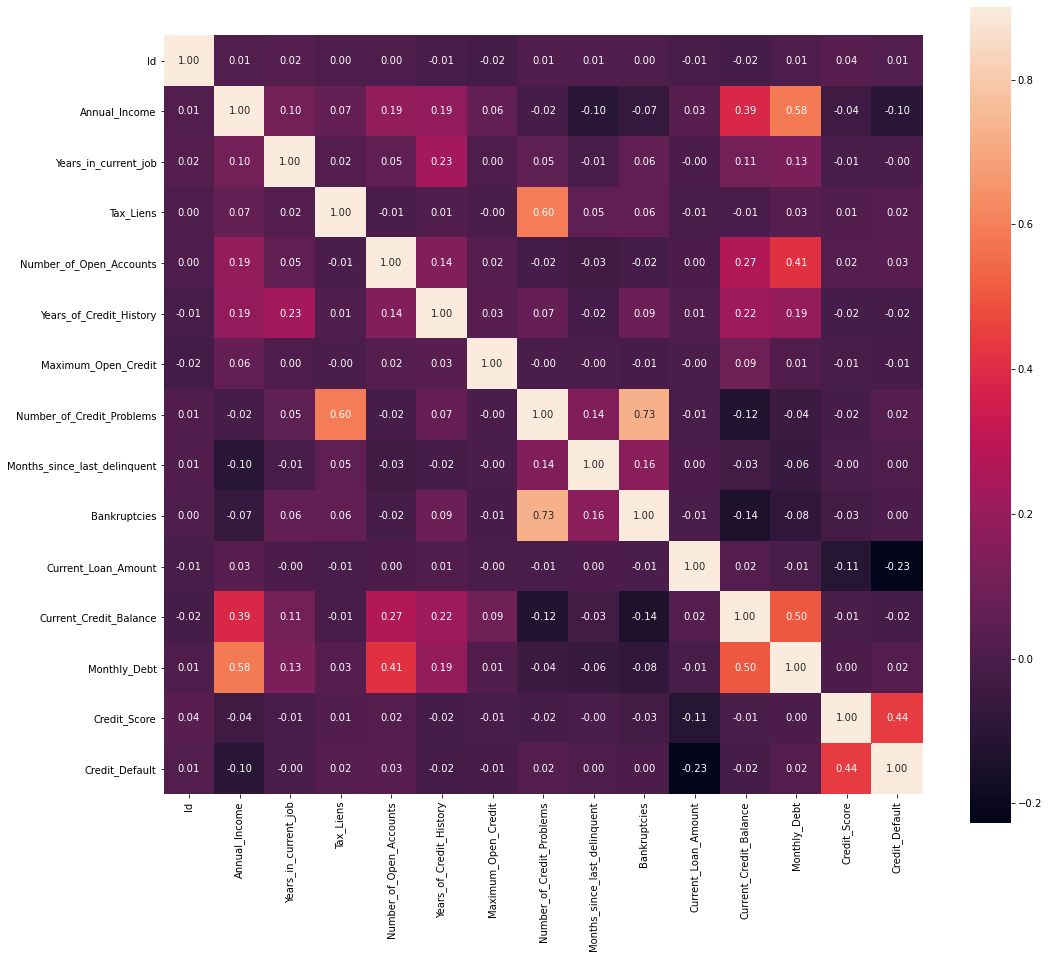

In [270]:
#correlation matrix
corrmat = trainDf.corr()
f, ax = plt.subplots(figsize=(17, 15))
#sns.set(font_scale=1.3)
sns.heatmap(corrmat, vmax=.9, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

# Imputing Bankruptcies column

In [271]:
s = np.abs(corrmat['Bankruptcies']).sort_values(ascending=False)
s

Bankruptcies                    1.00000000
Number_of_Credit_Problems       0.73075062
Months_since_last_delinquent    0.16271016
Current_Credit_Balance          0.14284940
Years_of_Credit_History         0.08569900
Monthly_Debt                    0.07957917
Annual_Income                   0.06687717
Years_in_current_job            0.05783777
Tax_Liens                       0.05736026
Credit_Score                    0.02748767
Number_of_Open_Accounts         0.01912973
Maximum_Open_Credit             0.01164960
Current_Loan_Amount             0.00598704
Id                              0.00318344
Credit_Default                  0.00164777
Name: Bankruptcies, dtype: float64

In [272]:
trainDf['Bankruptcies'].value_counts(dropna = False)

0.0    6660
1.0     786
2.0      31
NaN      14
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [273]:
trainDf[["Bankruptcies", "Number_of_Credit_Problems"]].groupby(['Bankruptcies'], dropna=False, as_index=False).count().sort_values(by='Number_of_Credit_Problems', ascending=False)

trainDf[["Bankruptcies", "Number_of_Credit_Problems"]].groupby(['Bankruptcies'], dropna=False, as_index=False).agg({'Number_of_Credit_Problems': ['mean', 'sum', 'count', 'min', 'max']})

# trainDf.groupby(['Years_in_current_job'], dropna=False).agg({'Current_Credit_Balance': ['mean', 'sum', 'min', 'max']})

Bankruptcies Number_of_Credit_Problems                       
                                    mean    sum count  min  max
0          0.0                0.04729730  315.0  6660  0.0  7.0
1          1.0                1.09414758  860.0   786  1.0  6.0
2          2.0                2.29032258   71.0    31  2.0  6.0
3          3.0                3.00000000   21.0     7  3.0  3.0
4          4.0                4.00000000    8.0     2  4.0  4.0
5          NaN                0.00000000    0.0    14  0.0  0.0

In [274]:
# filling the missing values of "Bankruptcies" column by conidering the value which is present in column "Number_of_Credit_Problems", 
# as we can notice from the correlation heap map, Bankruptcies is 73% correlated to Number_of_Credit_Problems
filtered_df = trainDf[trainDf['Bankruptcies'].isnull()]
filtered_df
#filtered_df.shape

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
100    100       Own Home       337079.0                   1.0        0.0   
256    256           Rent       857660.0                   1.0        0.0   
257    257  Home Mortgage            NaN                   2.0        0.0   
898    898           Rent       739005.0                   2.0        0.0   
1404  1404           Rent       349391.0                   0.5        0.0   
3063  3063           Rent       464474.0                  10.0        0.0   
3252  3252           Rent       832770.0                   0.5        0.0   
3351  3351  Home Mortgage      2226192.0                   8.0        0.0   
3401  3401           Rent       326154.0                   6.0        0.0   
3496  3496           Rent       233567.0                   1.0        0.0   
4334  4334           Rent       772749.0                   0.5        0.0   
5566  5566       Own Home            NaN                   0.5        0.0   
7184  7184           Rent       240122.0                   0.5        0.0   
7379  7379       Own Home       290415.0                   0.5        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
100                       9.0                     39.6             644204.0   
256                       6.0                     19.7             291082.0   
257                      15.0                     13.6            1556390.0   
898                      20.0                     18.3            2177758.0   
1404                      4.0                     12.7                  0.0   
3063                      5.0                     14.9              38126.0   
3252                      7.0                     16.5             636856.0   
3351                     14.0                     23.3             792836.0   
3401                      2.0                     19.1                  0.0   
3496                      7.0                     11.7                  0.0   
4334                      9.0                     19.6             575124.0   
5566                     12.0                     24.7             594594.0   
7184                      3.0                     12.9              11132.0   
7379                     16.0                     12.5             116644.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
100                         0.0                           0.0           NaN   
256                         0.0                           0.0           NaN   
257                         0.0                           0.0           NaN   
898                         0.0                           0.0           NaN   
1404                        0.0                           0.0           NaN   
3063                        0.0                           0.0           NaN   
3252                        0.0                           0.0           NaN   
3351                        0.0                          73.0           NaN   
3401                        0.0                          77.0           NaN   
3496                        0.0                           0.0           NaN   
4334                        0.0                          19.0           NaN   
5566                        0.0                           0.0           NaN   
7184                        0.0                           0.0           NaN   
7379                        0.0                           0.0           NaN   

                   Purpose        Term  Current_Loan_Amount  \
100   educational expenses  Short Term           99999999.0   
256     debt consolidation  Short Term           99999999.0   
257     debt consolidation  Short Term             447480.0   
898     debt consolidation  Short Term             456808.0   
1404                 other  Short Term              11242.0   
3063                 other  Short Term              44814.0   
3252         business loan  Short Term 

In [275]:
trainDf['Bankruptcies'] = trainDf['Bankruptcies'].fillna(trainDf['Number_of_Credit_Problems'])

In [276]:
trainDf.isnull().sum().sort_values(ascending=False)

Months_since_last_delinquent    4081
Annual_Income                   1557
Credit_Score                    1557
Years_in_current_job             371
Credit_Default                     0
Maximum_Open_Credit                0
Home_Ownership                     0
Tax_Liens                          0
Number_of_Open_Accounts            0
Years_of_Credit_History            0
Number_of_Credit_Problems          0
Bankruptcies                       0
Purpose                            0
Term                               0
Current_Loan_Amount                0
Current_Credit_Balance             0
Monthly_Debt                       0
Id                                 0
dtype: int64

In [277]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home_Ownership                7500 non-null   object 
 2   Annual_Income                 5943 non-null   float64
 3   Years_in_current_job          7129 non-null   float64
 4   Tax_Liens                     7500 non-null   float64
 5   Number_of_Open_Accounts       7500 non-null   float64
 6   Years_of_Credit_History       7500 non-null   float64
 7   Maximum_Open_Credit           7500 non-null   float64
 8   Number_of_Credit_Problems     7500 non-null   float64
 9   Months_since_last_delinquent  3419 non-null   float64
 10  Bankruptcies                  7500 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

# Imputing Years_in_current_job column

In [278]:
s = np.abs(corrmat['Years_in_current_job']).sort_values(ascending=False)
s

Years_in_current_job            1.00000000
Years_of_Credit_History         0.23441263
Monthly_Debt                    0.12547452
Current_Credit_Balance          0.11075770
Annual_Income                   0.10405881
Bankruptcies                    0.05783777
Number_of_Open_Accounts         0.05443800
Number_of_Credit_Problems       0.04995470
Id                              0.02172458
Tax_Liens                       0.01753118
Credit_Score                    0.00944494
Months_since_last_delinquent    0.00815420
Credit_Default                  0.00432444
Maximum_Open_Credit             0.00310207
Current_Loan_Amount             0.00170741
Name: Years_in_current_job, dtype: float64

In [279]:
trainDf['Years_in_current_job'].value_counts(dropna=False)

10.0    2332
2.0      705
3.0      620
0.5      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
NaN      371
8.0      339
9.0      259
Name: Years_in_current_job, dtype: int64

In [280]:
# Monthly_Debt
# Current_Credit_Balance
# Years_of_Credit_History

# trainDf[["Years_in_current_job", "Years_of_Credit_History"]].groupby(['Years_in_current_job'], as_index=False).min().sort_values(by='Years_of_Credit_History', ascending=False)

# trainDf[["Years_in_current_job", "Years_of_Credit_History"]].groupby(['Years_in_current_job']).agg({'Years_of_Credit_History': ['mean', 'min', 'max']}).sort_values(by='Years_of_Credit_History', ascending=False)

# trainDf.groupby(['Years_in_current_job', 'Monthly_Debt']).agg({'Years_of_Credit_History': ['mean', 'min', 'max']})

trainDf.groupby(['Years_in_current_job']).agg({'Monthly_Debt': ['mean', 'min', 'max']})

trainDf.groupby(['Years_in_current_job'], dropna=False).agg({'Current_Credit_Balance': ['mean', 'sum', 'count', 'min', 'max'], 'Annual_Income': ['mean', 'sum', 'count', 'min', 'max']})


Current_Credit_Balance                          \
                                       mean          sum count  min   
Years_in_current_job                                                  
0.5                         254504.05506217  143285783.0   563  0.0   
1.0                         255974.06944444  129010931.0   504  0.0   
2.0                         258549.60141844  182277469.0   705  0.0   
3.0                         256376.43870968  158953392.0   620  0.0   
4.0                         250922.54797441  117682675.0   469  0.0   
5.0                         272394.05232558  140555331.0   516  0.0   
6.0                         279583.21596244  119102450.0   426  0.0   
7.0                         261129.90656566  103407443.0   396  0.0   
8.0                         308857.38643068  104702654.0   339  0.0   
9.0                         344357.98069498   89188717.0   259  0.0   
10.0                        338754.70711835  789975977.0  2332  0.0   
NaN                         257699.30458221   95606442.0   371  0.0   

                                  Annual_Income                                \
                            max            mean           sum count       min   
Years_in_current_job                                                            
0.5                   3547262.0  1.20472305e+06   538511205.0   447  233453.0   
1.0                   4249673.0  1.26881112e+06   504986826.0   398  226252.0   
2.0                   2913707.0  1.32451668e+06   740404825.0   559  192223.0   
3.0                   2325467.0  1.39648728e+06   684278768.0   490  225112.0   
4.0                   4720132.0  1.37173345e+06   507541376.0   370  402990.0   
5.0                   2784108.0  1.33078557e+06   526991087.0   396  308408.0   
6.0                   1985462.0  1.31173012e+06   460417272.0   351  326154.0   
7.0                   2059942.0  1.34180505e+06   413275954.0   308  164597.0   
8.0                   2063875.0  1.39080027e+06   389424076.0   280  282929.0   
9.0                   6506797.0  1.44442936e+06   272997149.0   189  285779.0   
10.0                  4367245.0  1.51059805e+06  2808201767.0  1859  191577.0   
NaN                   4209659.0  9.23769216e+05   273435688.0   296  175845.0   

                                  
                             max  
Years_in_current_job              
0.5                    5798040.0  
1.0                    7476880.0  
2.0                    8710740.0  
3.0                    8923844.0  
4.0                    7660648.0  
5.0                   10149344.0  
6.0                    3888160.0  
7.0                    7381842.0  
8.0                    4772800.0  
9.0                    7883442.0  
10.0                   9338880.0  
NaN                    3904215.0

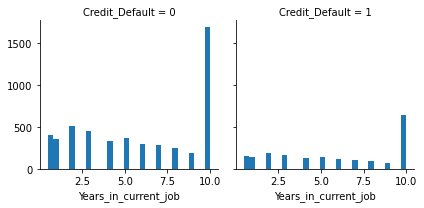

In [281]:
# g = sns.FacetGrid(trainDf, col='Credit_Default')
# g.map(plt.hist, 'Years_in_current_job', bins=30)

g = sns.FacetGrid(trainDf, col='Credit_Default')
g.map(plt.hist, 'Years_in_current_job', bins=30)


In [282]:
trainDf['Years_in_current_job'] = trainDf['Years_in_current_job'].fillna(0)

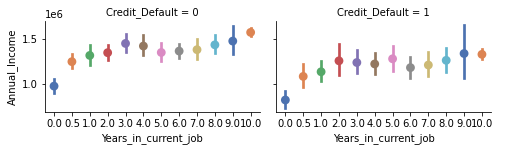

In [283]:
# grid = sns.FacetGrid(trainDf, row='Credit_Default', size=2.2, aspect=1.6)
# grid.map(sns.pointplot, 'Years_in_current_job', 'Home_Ownership_Home Mortgage', 'Sex', palette='deep')
# grid.add_legend()

grid = sns.FacetGrid(trainDf, col='Credit_Default', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Years_in_current_job', 'Annual_Income', palette='deep')
grid.add_legend()


In [284]:
trainDf.isnull().sum().sort_values(ascending=False)

Months_since_last_delinquent    4081
Annual_Income                   1557
Credit_Score                    1557
Credit_Default                     0
Maximum_Open_Credit                0
Home_Ownership                     0
Years_in_current_job               0
Tax_Liens                          0
Number_of_Open_Accounts            0
Years_of_Credit_History            0
Number_of_Credit_Problems          0
Bankruptcies                       0
Purpose                            0
Term                               0
Current_Loan_Amount                0
Current_Credit_Balance             0
Monthly_Debt                       0
Id                                 0
dtype: int64

# Imputing Annual_Income column

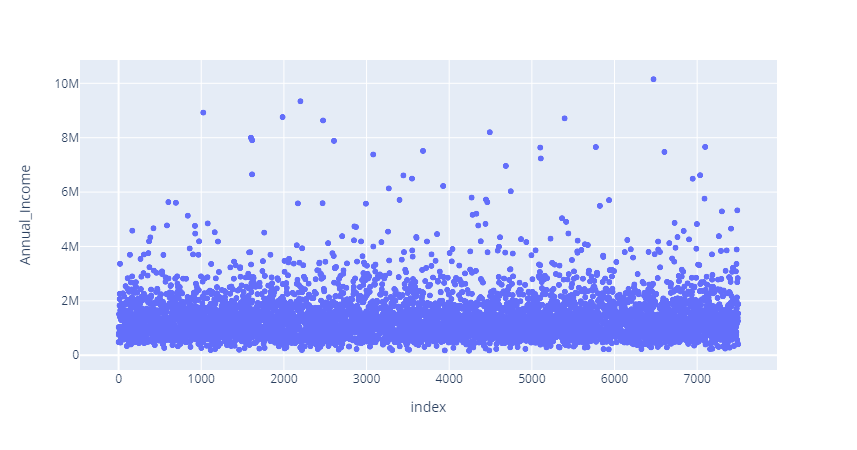

In [285]:
px.scatter(trainDf, y='Annual_Income')

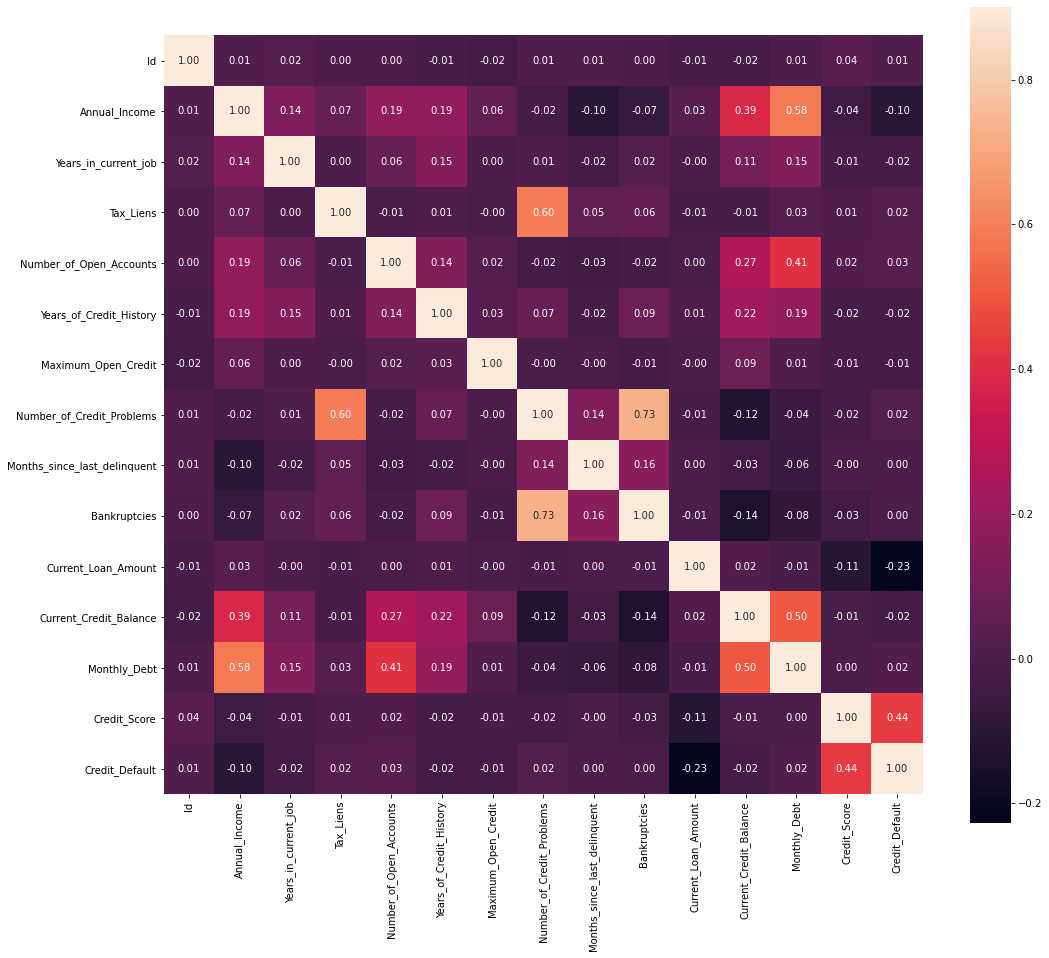

In [286]:
#correlation matrix
corrmat = trainDf.corr()
f, ax = plt.subplots(figsize=(17, 15))
#sns.set(font_scale=1.3)
sns.heatmap(corrmat, vmax=.9, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

In [287]:
s = np.abs(corrmat['Annual_Income']).sort_values(ascending=False)
s

Annual_Income                   1.00000000
Monthly_Debt                    0.58481909
Current_Credit_Balance          0.38648064
Number_of_Open_Accounts         0.18852398
Years_of_Credit_History         0.18653127
Years_in_current_job            0.13767936
Months_since_last_delinquent    0.10178664
Credit_Default                  0.10137545
Tax_Liens                       0.06624486
Bankruptcies                    0.06621002
Maximum_Open_Credit             0.06221791
Credit_Score                    0.03783175
Current_Loan_Amount             0.03208220
Number_of_Credit_Problems       0.01540741
Id                              0.01142576
Name: Annual_Income, dtype: float64

In [288]:
# pd.cut(trainDf['Monthly_Debt'], 5)
s = pd.cut(trainDf['Monthly_Debt'], bins=10).value_counts()
# s = trainDf.groupby(pd.cut(trainDf['Monthly_Debt'], bins=10)).size()
s

(13667.9, 27335.8]      3165
(-136.679, 13667.9]     3005
(27335.8, 41003.7]       972
(41003.7, 54671.6]       257
(54671.6, 68339.5]        69
(68339.5, 82007.4]        16
(82007.4, 95675.3]        11
(95675.3, 109343.2]        3
(123011.1, 136679.0]       1
(109343.2, 123011.1]       1
Name: Monthly_Debt, dtype: int64

In [289]:
# trainDf['Annual_Income'][(trainDf['Monthly_Debt'] >= 109343.2) & (trainDf['Monthly_Debt'] < 136679.0)].isnull().sum()

In [290]:
bins = 10
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
trainDf['Monthly_Debt_Binned'] = pd.cut(trainDf['Monthly_Debt'], bins=bins, labels=labels)
trainDf

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
0        0       Own Home       482087.0                   0.0        0.0   
1        1       Own Home      1025487.0                  10.0        0.0   
2        2  Home Mortgage       751412.0                   8.0        0.0   
3        3       Own Home       805068.0                   6.0        0.0   
4        4           Rent       776264.0                   8.0        0.0   
...    ...            ...            ...                   ...        ...   
7495  7495           Rent       402192.0                   0.5        0.0   
7496  7496  Home Mortgage      1533984.0                   1.0        0.0   
7497  7497           Rent      1878910.0                   6.0        0.0   
7498  7498  Home Mortgage            NaN                   0.0        0.0   
7499  7499           Rent            NaN                   4.0        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  \
0                    47386.0        7914.0         749.0               0   
1                   394972.0       18373.0         737.0               1   
2                   308389.0       13651.0         742.0               0   
3                    95855.0       11338.0         694.0               0   
4                    93309.0        7180.0         719.0               0

In [291]:
# trainDf1['value'] = trainDf[['Annual_Income']].groupby('Monthly_Debt_Binned').transform(lambda x: x.fillna(x.median()))
# df123 = trainDf[['Annual_Income', 'Monthly_Debt_Binned']].groupby('Monthly_Debt_Binned').transform(lambda x: x.fillna(x.median()))
# df123 = trainDf[['Annual_Income', 'Monthly_Debt_Binned']]
# df123 = df123.groupby('Monthly_Debt_Binned').transform(lambda x: x.fillna(x.median()))
# df123
trainDf['Annual_Income'] = trainDf.groupby('Monthly_Debt_Binned').transform(lambda x: x.fillna(x.median()))['Annual_Income']
trainDf
# df["value"] = df.groupby("name").transform(lambda x: x.fillna(x.mean()))['value']

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
0        0       Own Home       482087.0                   0.0        0.0   
1        1       Own Home      1025487.0                  10.0        0.0   
2        2  Home Mortgage       751412.0                   8.0        0.0   
3        3       Own Home       805068.0                   6.0        0.0   
4        4           Rent       776264.0                   8.0        0.0   
...    ...            ...            ...                   ...        ...   
7495  7495           Rent       402192.0                   0.5        0.0   
7496  7496  Home Mortgage      1533984.0                   1.0        0.0   
7497  7497           Rent      1878910.0                   6.0        0.0   
7498  7498  Home Mortgage      1733674.0                   0.0        0.0   
7499  7499           Rent       867274.0                   4.0        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  \
0                    47386.0        7914.0         749.0               0   
1                   394972.0       18373.0         737.0               1   
2                   308389.0       13651.0         742.0               0   
3                    95855.0       11338.0         694.0               0   
4                    93309.0        7180.0         719.0               0

In [292]:
# trainDf.groupby('Monthly_Debt_Binned').mean()['Annual_Income']

In [293]:
# df = pd.DataFrame({'value': [1, np.nan, np.nan, 2, 3, 1, 3, np.nan, 3], 'name': ['A','A', 'B','B','B','B', 'C','C','C']})
# df1 = df.groupby("name").transform(lambda x: x.fillna(x.mean()))
# # df.groupby("name").mean()
# df1

In [294]:
# trainDf.to_csv('Credit_Default_Prediction_1.csv', index=True, index_label='Id')

# Imputing Credit_Score column

In [295]:
trainDf.isnull().sum().sort_values(ascending=False)

Months_since_last_delinquent    4081
Credit_Score                    1557
Number_of_Credit_Problems          0
Home_Ownership                     0
Annual_Income                      0
Years_in_current_job               0
Tax_Liens                          0
Number_of_Open_Accounts            0
Years_of_Credit_History            0
Maximum_Open_Credit                0
Monthly_Debt_Binned                0
Credit_Default                     0
Bankruptcies                       0
Purpose                            0
Term                               0
Current_Loan_Amount                0
Current_Credit_Balance             0
Monthly_Debt                       0
Id                                 0
dtype: int64

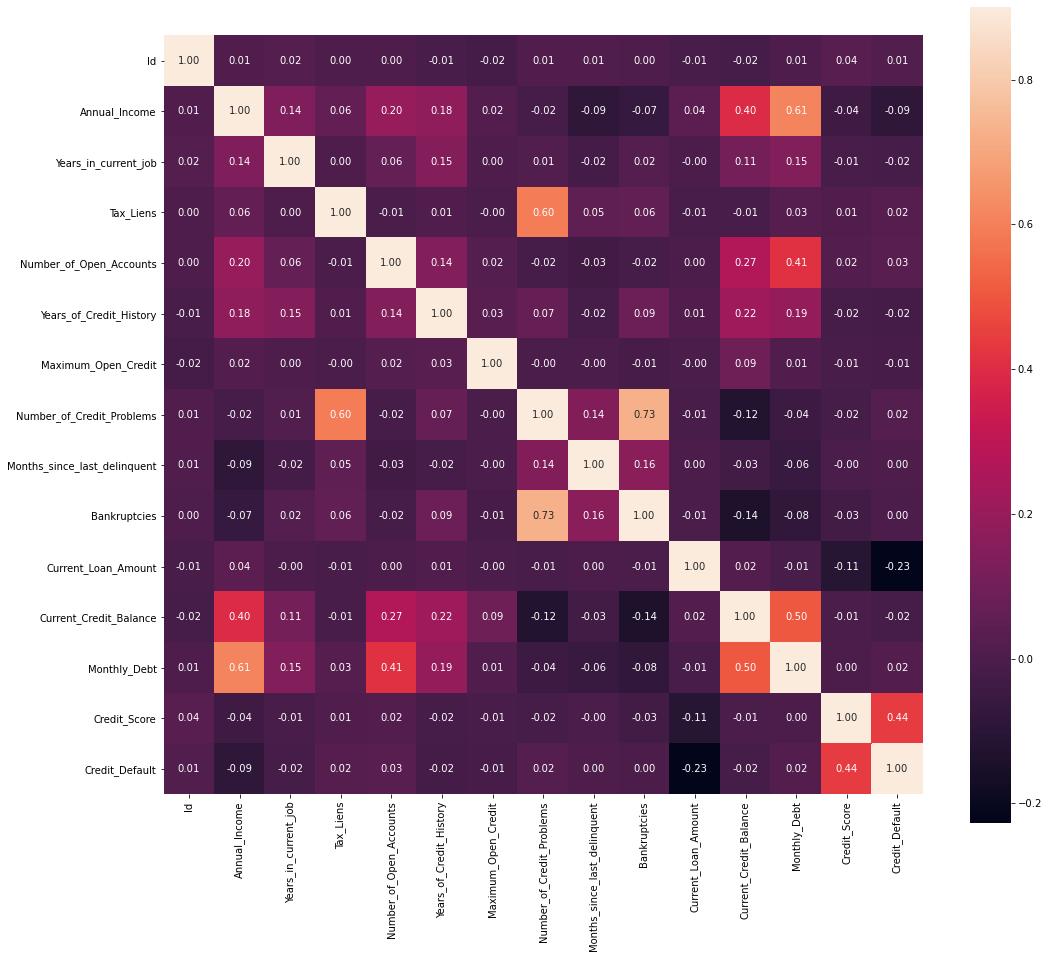

In [296]:
#correlation matrix
corrmat = trainDf.corr()
f, ax = plt.subplots(figsize=(17, 15))
#sns.set(font_scale=1.3)
sns.heatmap(corrmat, vmax=.9, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

<AxesSubplot:>

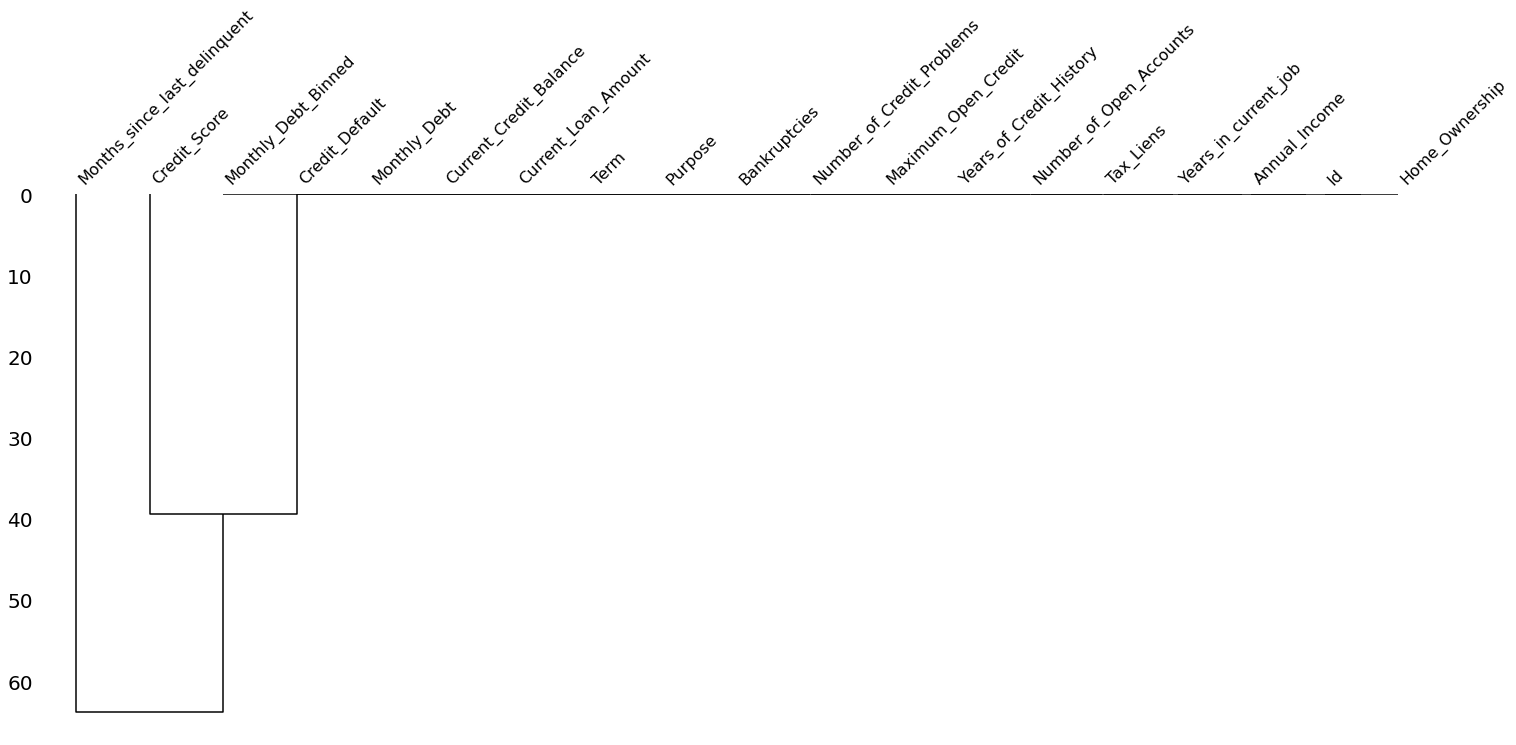

In [297]:
msno.dendrogram(trainDf)

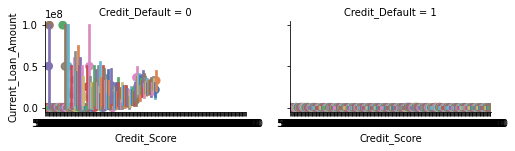

In [298]:
grid = sns.FacetGrid(trainDf, col='Credit_Default', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Credit_Score', 'Current_Loan_Amount', palette='deep')
grid.add_legend()

In [299]:
trainDf.columns.values

array(['Id', 'Home_Ownership', 'Annual_Income', 'Years_in_current_job',
       'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Months_since_last_delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
       'Credit_Score', 'Credit_Default', 'Monthly_Debt_Binned'],
      dtype=object)

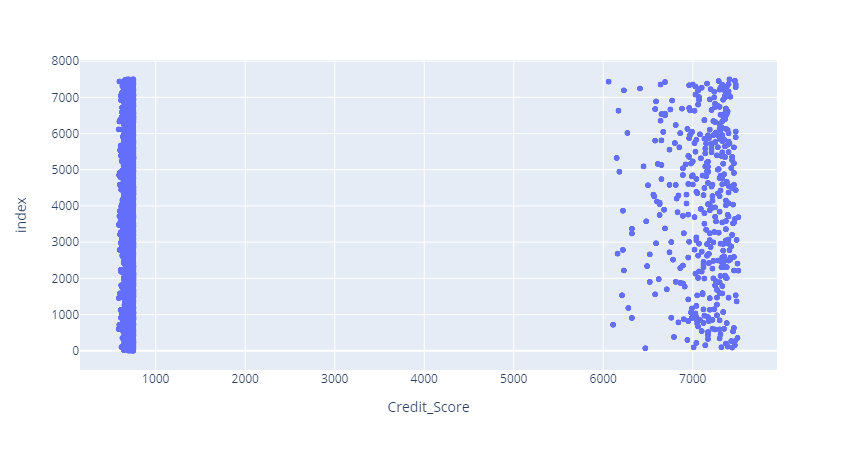

In [300]:
# finding any outliers presence in Credit_Score column by plotting histogram/scatter plot
px.scatter(trainDf, x='Credit_Score')

In [301]:
trainDf['Credit_Score'] = [score/10 if score > 800 else score for score in trainDf['Credit_Score']]
trainDf

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
0        0       Own Home       482087.0                   0.0        0.0   
1        1       Own Home      1025487.0                  10.0        0.0   
2        2  Home Mortgage       751412.0                   8.0        0.0   
3        3       Own Home       805068.0                   6.0        0.0   
4        4           Rent       776264.0                   8.0        0.0   
...    ...            ...            ...                   ...        ...   
7495  7495           Rent       402192.0                   0.5        0.0   
7496  7496  Home Mortgage      1533984.0                   1.0        0.0   
7497  7497           Rent      1878910.0                   6.0        0.0   
7498  7498  Home Mortgage      1733674.0                   0.0        0.0   
7499  7499           Rent       867274.0                   4.0        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  \
0                    47386.0        7914.0         749.0               0   
1                   394972.0       18373.0         737.0               1   
2                   308389.0       13651.0         742.0               0   
3                    95855.0       11338.0         694.0               0   
4                    93309.0        7180.0         719.0               0

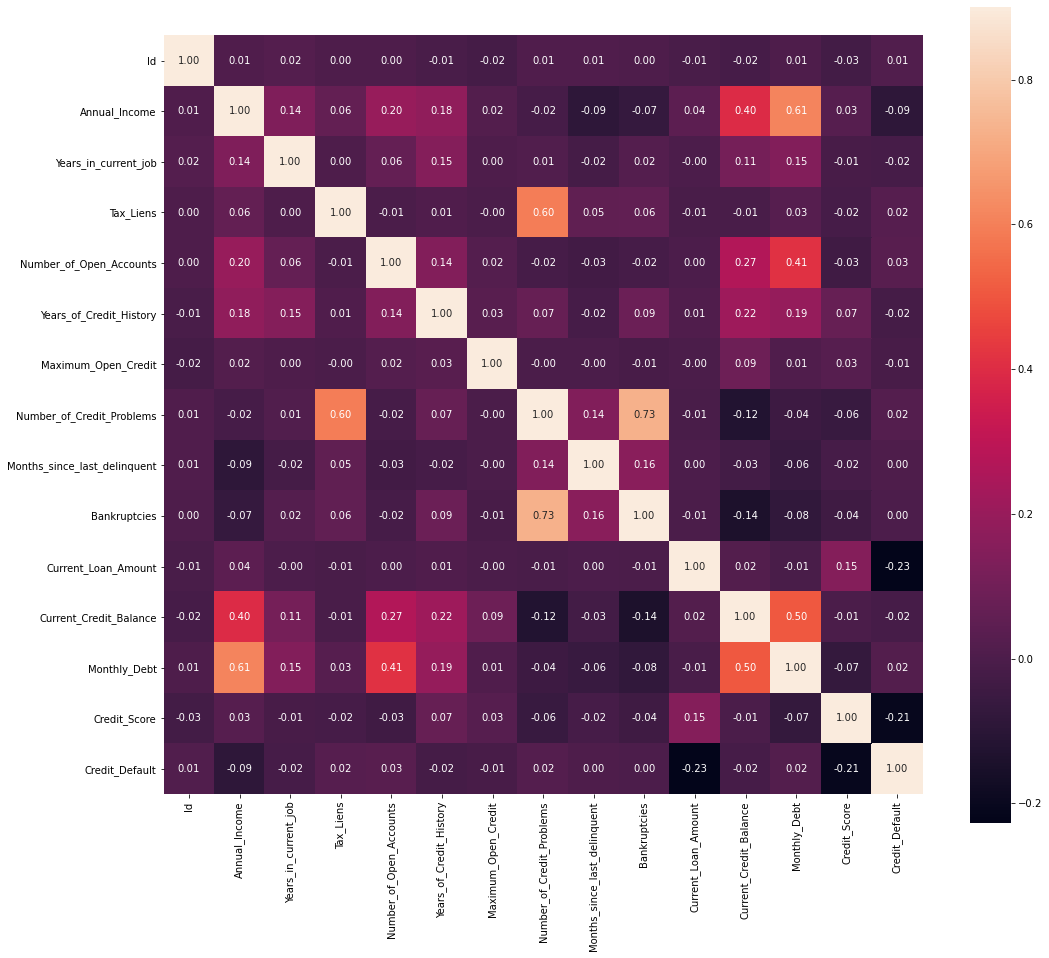

In [302]:
#correlation matrix
corrmat = trainDf.corr()
f, ax = plt.subplots(figsize=(17, 15))
#sns.set(font_scale=1.3)
sns.heatmap(corrmat, vmax=.9, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

In [303]:
s = np.abs(corrmat['Credit_Score']).sort_values(ascending=False)
s

Credit_Score                    1.00000000
Credit_Default                  0.20715460
Current_Loan_Amount             0.14920496
Monthly_Debt                    0.07054248
Years_of_Credit_History         0.06836350
Number_of_Credit_Problems       0.05509016
Bankruptcies                    0.04141993
Number_of_Open_Accounts         0.03475629
Annual_Income                   0.02857140
Id                              0.02822341
Maximum_Open_Credit             0.02820900
Months_since_last_delinquent    0.01652676
Tax_Liens                       0.01647770
Years_in_current_job            0.01404959
Current_Credit_Balance          0.00563905
Name: Credit_Score, dtype: float64

<AxesSubplot:>

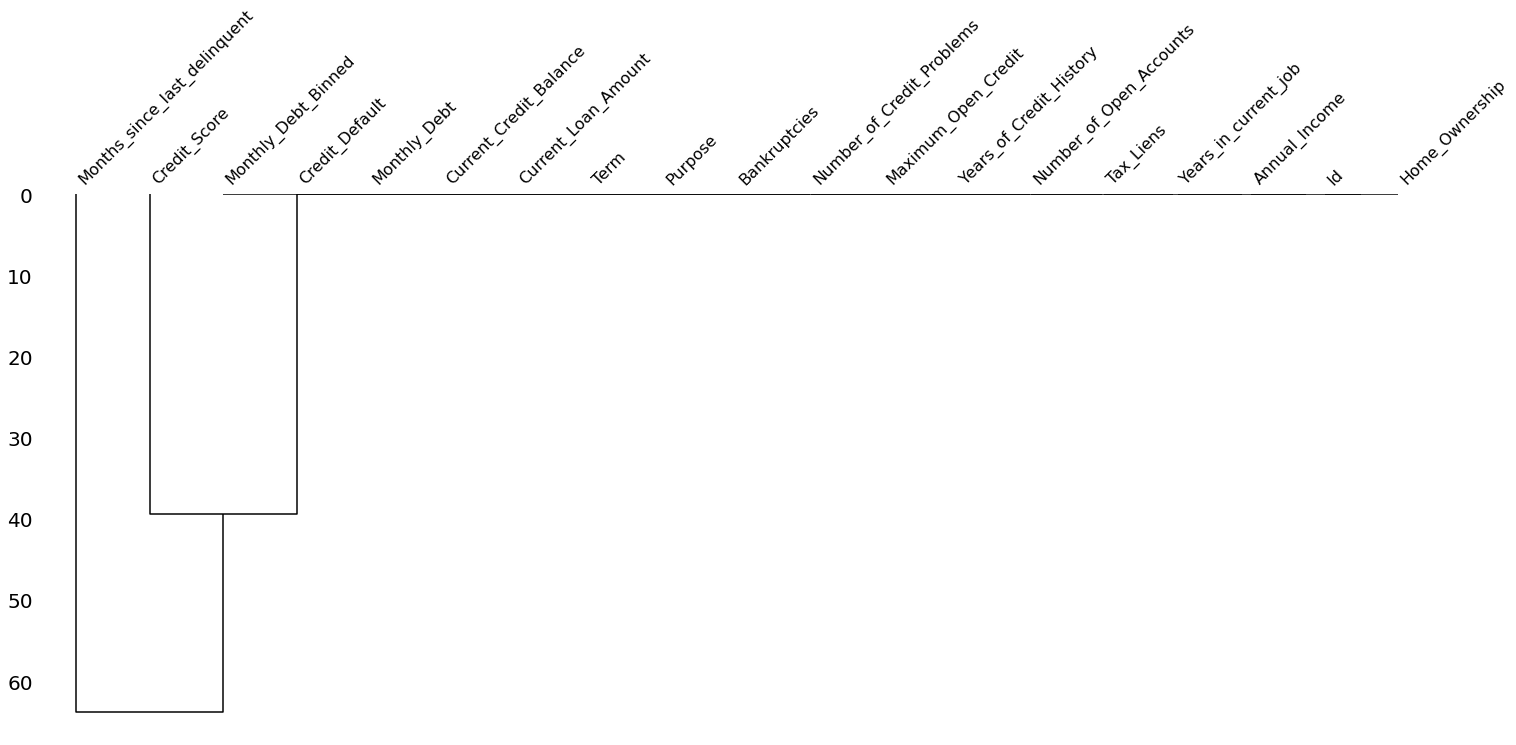

In [304]:
msno.dendrogram(trainDf)

In [305]:
bins = 10
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
trainDf['Current_Loan_Amount_Binning'] = pd.cut(trainDf['Current_Loan_Amount'], bins=bins, labels=labels)
trainDf

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
0        0       Own Home       482087.0                   0.0        0.0   
1        1       Own Home      1025487.0                  10.0        0.0   
2        2  Home Mortgage       751412.0                   8.0        0.0   
3        3       Own Home       805068.0                   6.0        0.0   
4        4           Rent       776264.0                   8.0        0.0   
...    ...            ...            ...                   ...        ...   
7495  7495           Rent       402192.0                   0.5        0.0   
7496  7496  Home Mortgage      1533984.0                   1.0        0.0   
7497  7497           Rent      1878910.0                   6.0        0.0   
7498  7498  Home Mortgage      1733674.0                   0.0        0.0   
7499  7499           Rent       867274.0                   4.0        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  \
0                    47386.0        7914.0         749.0               0   
1                   394972.0       18373.0         737.0               1   
2                   308389.0       13651.0         742.0               0   
3                    95855.0       11338.0         694.0               0   
4                    93309.0        7180.0         719.0               0

In [306]:
trainDf['Credit_Score'] = trainDf.groupby(['Credit_Default', 'Current_Loan_Amount_Binning']).transform(lambda x: x.fillna(x.median()))['Credit_Score']
trainDf

Id Home_Ownership  Annual_Income  Years_in_current_job  Tax_Liens  \
0        0       Own Home       482087.0                   0.0        0.0   
1        1       Own Home      1025487.0                  10.0        0.0   
2        2  Home Mortgage       751412.0                   8.0        0.0   
3        3       Own Home       805068.0                   6.0        0.0   
4        4           Rent       776264.0                   8.0        0.0   
...    ...            ...            ...                   ...        ...   
7495  7495           Rent       402192.0                   0.5        0.0   
7496  7496  Home Mortgage      1533984.0                   1.0        0.0   
7497  7497           Rent      1878910.0                   6.0        0.0   
7498  7498  Home Mortgage      1733674.0                   0.0        0.0   
7499  7499           Rent       867274.0                   4.0        0.0   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  \
0                    47386.0        7914.0         749.0               0   
1                   394972.0       18373.0         737.0               1   
2                   308389.0       13651.0         742.0               0   
3                    95855.0       11338.0         694.0               0   
4                    93309.0        7180.0         719.0               0

In [307]:
trainDf.isnull().sum()

Id                                 0
Home_Ownership                     0
Annual_Income                      0
Years_in_current_job               0
Tax_Liens                          0
Number_of_Open_Accounts            0
Years_of_Credit_History            0
Maximum_Open_Credit                0
Number_of_Credit_Problems          0
Months_since_last_delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current_Loan_Amount                0
Current_Credit_Balance             0
Monthly_Debt                       0
Credit_Score                       0
Credit_Default                     0
Monthly_Debt_Binned                0
Current_Loan_Amount_Binning        0
dtype: int64

# Imputing Months_since_last_delinquent feature

In [308]:
s = np.abs(corrmat['Months_since_last_delinquent']).sort_values(ascending=False)
s

Months_since_last_delinquent    1.00000000
Bankruptcies                    0.16323676
Number_of_Credit_Problems       0.13990475
Annual_Income                   0.08662443
Monthly_Debt                    0.05770201
Tax_Liens                       0.05244581
Number_of_Open_Accounts         0.03274040
Current_Credit_Balance          0.02719796
Years_in_current_job            0.02187992
Credit_Score                    0.01652676
Years_of_Credit_History         0.01537456
Id                              0.00726205
Maximum_Open_Credit             0.00384878
Credit_Default                  0.00259776
Current_Loan_Amount             0.00045943
Name: Months_since_last_delinquent, dtype: float64

- As seen above Months_since_last_delinquent is having minimum corrrelation with the target feature - Credit_Default and as it is having more than 50% of its data being missing, lets decide to drop that feature

In [310]:
trainDf.drop(['Months_since_last_delinquent'],inplace=True,axis=1)

In [311]:
trainDf.isnull().sum()

Id                             0
Home_Ownership                 0
Annual_Income                  0
Years_in_current_job           0
Tax_Liens                      0
Number_of_Open_Accounts        0
Years_of_Credit_History        0
Maximum_Open_Credit            0
Number_of_Credit_Problems      0
Bankruptcies                   0
Purpose                        0
Term                           0
Current_Loan_Amount            0
Current_Credit_Balance         0
Monthly_Debt                   0
Credit_Score                   0
Credit_Default                 0
Monthly_Debt_Binned            0
Current_Loan_Amount_Binning    0
dtype: int64